In [1]:
# Load the Libraries
import numpy as np
import matplotlib.pyplot as plt
import math

## Data Set
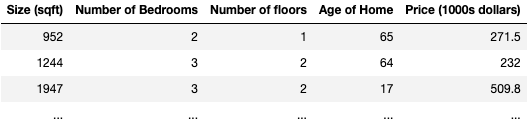

In [2]:
# Load the Data Set
def load_house_data():
    data = np.loadtxt("houses.txt", delimiter=',', skiprows=1)
    X = data[:,:4]
    y = data[:,4]
    return X, y

X_train, y_train = load_house_data()
X_features = ['Size(sqft)','Bedrooms','Floors','Age']

print(f"Shape of the Data Set: {X_train.shape}")
print(f"Number of Training Examples: {X_train.shape[0]}")
print(f"Number of Features: {X_train.shape[1]}")

Shape of the Data Set: (99, 4)
Number of Training Examples: 99
Number of Features: 4


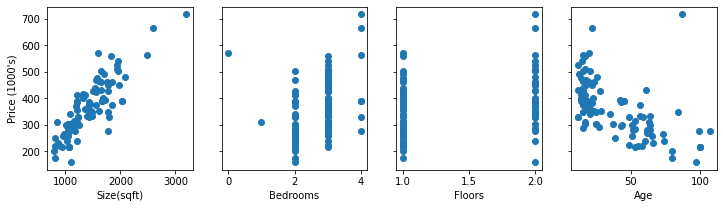

In [3]:
# Visualize the Data Set

# Size and Age seems to have the strongest influence on Price.
fig,ax=plt.subplots(1, 4, figsize=(12, 3), sharey=True)
for i in range(len(ax)):
    ax[i].scatter(X_train[:,i],y_train)
    ax[i].set_xlabel(X_features[i])
ax[0].set_ylabel("Price (1000's)")
plt.show()

## Feature Scaling (Z-Score Normalization)

Z-Score Normalization, also known as Standardization, is a feature scaling technique used in preprocessing data for machine learning and statistical analysis. The goal of Z-Score Normalization is to transform the features in a dataset to have a mean of 0 and a standard deviation of 1, which helps ensure that all features are on a similar scale and have comparable importance in the subsequent analysis or modeling.

To implement Z-Score normalization, adjust your input values as shown in this formula:
$$x^{(i)}_j = \dfrac{x^{(i)}_j - \mu_j}{\sigma_j} \tag{4}$$ 
where $j$ selects a feature or a column in the $\mathbf{X}$ matrix. $µ_j$ is the mean of all the values for feature (j) and $\sigma_j$ is the standard deviation of feature (j).
$$
\begin{align}
\mu_j &= \frac{1}{m} \sum_{i=0}^{m-1} x^{(i)}_j \tag{5}\\
\sigma^2_j &= \frac{1}{m} \sum_{i=0}^{m-1} (x^{(i)}_j - \mu_j)^2  \tag{6}
\end{align}
$$

>**Implementation Note:** When normalizing the features, it is important
to store the values used for normalization - the mean value and the standard deviation used for the computations. After learning the parameters
from the model, we often want to predict the prices of houses we have not
seen before. Given a new x value (living room area and number of bed-
rooms), we must first normalize x using the mean and standard deviation
that we had previously computed from the training set.

In [4]:
def zscore_normalize_features(X):
    """
    Computes  X, Z-Score Normalized by Column
    
    Args:
      X (ndarray (m,n))     : input data, m examples, n features
      
    Returns:
      X_norm (ndarray (m,n)): input normalized by column
      mu (ndarray (n,))     : mean of each feature
      sigma (ndarray (n,))  : standard deviation of each feature
    """
    # Mean of each Column/ Feature
    # axis = 0 -> Column
    mu = np.mean(X, axis = 0)
    
    # Standard Deviation of each Column/ Feature
    # axis = 0 -> Column
    sigma = np.std(X, axis = 0)
    
    # Element-Wise, Subtract mu for that Column from each Example, Divide by std for that Column
    X_norm = (X - mu) / sigma
    
    return X_norm, mu, sigma

In [5]:
# Normalize the Original Features
X_norm, X_mu, X_sigma = zscore_normalize_features(X_train)
print(f"X_mu = {X_mu}, \nX_sigma = {X_sigma}")
print(f"Peak to Peak Range by Column in Raw        X: {np.ptp(X_train,axis=0)}")   
print(f"Peak to Peak Range by Column in Normalized X: {np.ptp(X_norm,axis=0)}")

X_mu = [1.41837374e+03 2.71717172e+00 1.38383838e+00 3.83838384e+01], 
X_sigma = [411.61562893   0.65196523   0.48631932  25.77788069]
Peak to Peak Range by Column in Raw        X: [2.406e+03 4.000e+00 1.000e+00 9.500e+01]
Peak to Peak Range by Column in Normalized X: [5.8452591  6.13529646 2.05626214 3.68533012]


## Model

In [6]:
def compute_cost(X, y, w, b):
    """
    compute cost
    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters  
      b (scalar)       : model parameter
      
    Returns:
      cost (scalar): cost
    """
    # Number of Training Examples:
    m = X.shape[0]
    
    # Cost
    cost = 0
    
    for i in range(m):
        f_wb_i = np.dot(w, X[i]) + b
        cost += (f_wb_i - y[i])**2
    cost = cost/(2*m)
    return cost



def compute_gradient(X, y, w, b): 
    """
    Computes the gradient for linear regression 
    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters  
      b (scalar)       : model parameter
      
    Returns:
      dj_dw (ndarray (n,)): The gradient of the cost w.r.t. the parameters w. 
      dj_db (scalar):       The gradient of the cost w.r.t. the parameter b. 
    """
    # Number of Training Examples
    m = X.shape[0]
    
    # Number of Features (and w)
    n = X.shape[1]
    
    # Gradients
    dj_dw = np.zeros(n)
    dj_db = 0
    
    # For Each Training Example
    for i in range(m):
        error_i = (np.dot(w, X[i]) + b) - y[i]

        # For Each Feature 
        for j in range(n):
            # Update the Gradient of the Corresponding Weight w[j] 
            # by Adding the Product of the Error and the Current Feature Value
            dj_dw[j] += error_i * X[i, j]
        dj_db += error_i
    dj_dw = dj_dw / m                                
    dj_db = dj_db / m                                
        
    return dj_db, dj_dw



def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters): 
    """
    Performs batch gradient descent to learn w and b. Updates w and b by taking 
    num_iters gradient steps with learning rate alpha
    
    Args:
      X (ndarray (m,n))   : Data, m examples with n features
      y (ndarray (m,))    : target values
      w_in (ndarray (n,)) : initial model parameters  
      b_in (scalar)       : initial model parameter
      cost_function       : function to compute cost
      gradient_function   : function to compute the gradient
      alpha (float)       : Learning rate
      num_iters (int)     : number of iterations to run gradient descent
      
    Returns:
      w (ndarray (n,)) : Updated values of parameters 
      b (scalar)       : Updated value of parameter 
    """
    J_history = []
    w = w_in
    b = b_in
    
    # Until Convergence
    for i in range(num_iters):
        dj_db, dj_dw = gradient_function(X, y, w, b)
        
        # Update the Parameters
        w = w - (alpha * dj_dw)
        b = b - (alpha * dj_db)
        
        # Save Cost J at Each Iteration
        if i<100000: # Prevent Resource Exhaustion 
            J_history.append(cost_function(X, y, w, b))
        
        # Save and Print Cost at Each Hundredth Iteration
        if (i%100) == 0:
            print(f"Iteration {i:4d}, Cost: {J_history[i]:8.2f}")
            
    return w, b, J_history

In [7]:
# Run Gradient Descent with Normalized Data
m, n = X_norm.shape
w_in = np.zeros(n)
b_in = 0

w_norm, b_norm, hist = gradient_descent(X_norm, y_train, w_in, b_in, compute_cost, compute_gradient, 1.0e-1, 1000)
print(f"w_norm: {w_norm}")
print(f"b_norm: {b_norm}")

Iteration    0, Cost: 57617.03
Iteration  100, Cost:   221.09
Iteration  200, Cost:   219.21
Iteration  300, Cost:   219.21
Iteration  400, Cost:   219.21
Iteration  500, Cost:   219.21
Iteration  600, Cost:   219.21
Iteration  700, Cost:   219.21
Iteration  800, Cost:   219.21
Iteration  900, Cost:   219.21
w_norm: [110.56039756 -21.26715096 -32.70718139 -37.97015909]
b_norm: 363.15608080808056


## Results

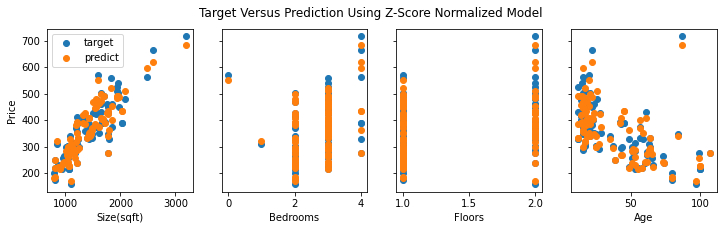

In [8]:
# Predict Target Using Normalized Features
m = X_norm.shape[0]
yp = np.zeros(m)
for i in range(m):
    yp[i] = np.dot(X_norm[i], w_norm) + b_norm

    # Plot Predictions and Targets Versus Original Features    
fig,ax=plt.subplots(1,4,figsize=(12, 3),sharey=True)
for i in range(len(ax)):
    ax[i].scatter(X_train[:,i],y_train, label = 'target')
    ax[i].set_xlabel(X_features[i])
    ax[i].scatter(X_train[:,i],yp, label = 'predict')
ax[0].set_ylabel("Price"); ax[0].legend();
fig.suptitle("Target Versus Prediction Using Z-Score Normalized Model")
plt.show()

The results look good. A few points to note:
- With multiple features, we can no longer have a single plot showing results versus features.
- When generating the plot, the normalized features were used. Any predictions using the parameters learned from a normalized training set must also be normalized.

In [9]:
# First, Normalize the Example
x_house = np.array([1200, 3, 1, 40])
x_house_norm = (x_house - X_mu) / X_sigma
print(x_house_norm)
x_house_predict = np.dot(x_house_norm, w_norm) + b_norm
print(f"Predicted Price of a House with 1200 sqft, 3 bedrooms, 1 floor, 40 years old = ${x_house_predict*1000:0.0f}")

[-0.53052829  0.43380884 -0.78927234  0.06269567]
Predicted Price of a House with 1200 sqft, 3 bedrooms, 1 floor, 40 years old = $318709
